In [1]:
"""
Created on Fri Jun 20 08:47:46 2025

@author: kennyaskelson
"""

'\nCreated on Fri Jun 20 08:47:46 2025\n\n@author: kennyaskelson\n'

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

In [3]:
df = pd.read_json('public_cases.json')

In [4]:
# Expand the 'input' column into its own DataFrame
input_expanded = pd.json_normalize(df['input'])

In [5]:
# Combine it back with the original expected_output column
df_cleaned = pd.concat([input_expanded, df['expected_output']], axis=1)

In [6]:
# Split features (X) and target (y)
X = df_cleaned[['trip_duration_days', 'miles_traveled', 'total_receipts_amount']]
y = df_cleaned[['expected_output']]

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Here we will set up the parameter space to search for the best model
n_estimators is the number of decision trees in the forest
max_depth number of levels in each decision tree
min_samples_split is the minimum number of samples required to split a node
min_samples_leaf minimum number of samples required at each leaf node
max_features number of features to consider at every split

In [8]:
param_dist = {
    'n_estimators': [100, 200, 300, 500, 750, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50, 60],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [9]:
rf = RandomForestRegressor(random_state=42)

In [10]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,  # Increase for a more thorough search
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [11]:
random_search.fit(X_train, y_train.values.ravel())  # Flatten y_train if needed

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500,
                                                         750, 1000]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [12]:
best_model = random_search.best_estimator_
test_predictions = best_model.predict(X_test)
print("Best MAE:", mean_absolute_error(y_test, test_predictions))
print(random_search.best_params_)

Best MAE: 63.970374275349776
{'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}


Best MAE: 63.970374275349776

Best params {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}

Make plot of predicitions 

Text(0, 0.5, 'Predictions (expenses)')

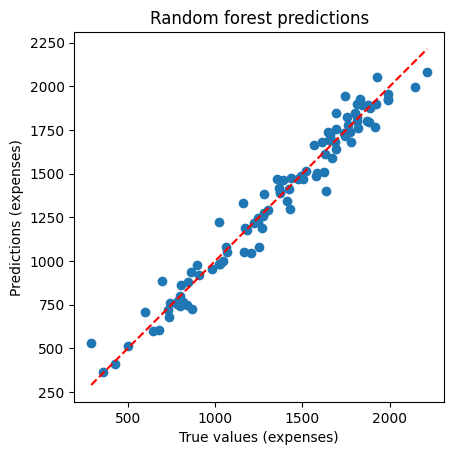

In [13]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions )
plt.title('Random forest predictions')
## Make a 1-to-1 line
y_true = np.array(y_test)
y_pred = np.array(test_predictions)
min_val = np.min([y_true.min(), y_pred.min()])
max_val = np.max([y_true.max(), y_pred.max()])
# Plot 1-to-1 reference line
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')

To save model 
Save the model
joblib.dump(best_model, 'reimbursement_model.joblib')